In [1]:
pip install git+https://github.com/RJT1990/pyflux

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/RJT1990/pyflux to /tmp/pip-req-build-poqx0d7z
  Running command git clone --filter=blob:none --quiet https://github.com/RJT1990/pyflux /tmp/pip-req-build-poqx0d7z
  Resolved https://github.com/RJT1990/pyflux to commit 297f2afc2095acd97c12e827dd500e8ea5da0c0f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 KB 2.4 MB/s eta 0:00:00
  Created wheel for pyflux: filename=pyflux-0.4.17-cp39-cp39-linux_x86_64.whl size=7469412 sha256=ec65562fef136d60095f8b4f6a81c788de5acdeee6c8703d73386740b96ce3f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-y1j01jkj/wheels/e2/77/8a/47c411cf67e59bda35b3780966afb9949ac5993c73aea067b2
Successfully built pyflux


In [15]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [16]:
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2021, 8, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

[*********************100%***********************]  1 of 1 completed


In [17]:
ret =100* s_p500['Adj Close'].pct_change().iloc[1:]

In [18]:
realized_vol = ret.rolling(window=5).std()

In [19]:
n=252

Index    Latent Variable           Prior           Prior Hyperparameters     V.I. Dist  Transform 
======== ========================= =============== ========================= ========== ==========
0        Vol Constant              Normal          mu0: 0, sigma0: 3         Normal     exp       
1        q(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
2        p(1)                      Normal          mu0: 0, sigma0: 0.5       Normal     logit     
3        Returns Constant          Normal          mu0: 0, sigma0: 3         Normal     None      
Acceptance rate of Metropolis-Hastings is 0.11685
Acceptance rate of Metropolis-Hastings is 0.18025
Acceptance rate of Metropolis-Hastings is 0.25605

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2515
GARCH(1,1)                                                                                                
======================================================= ============

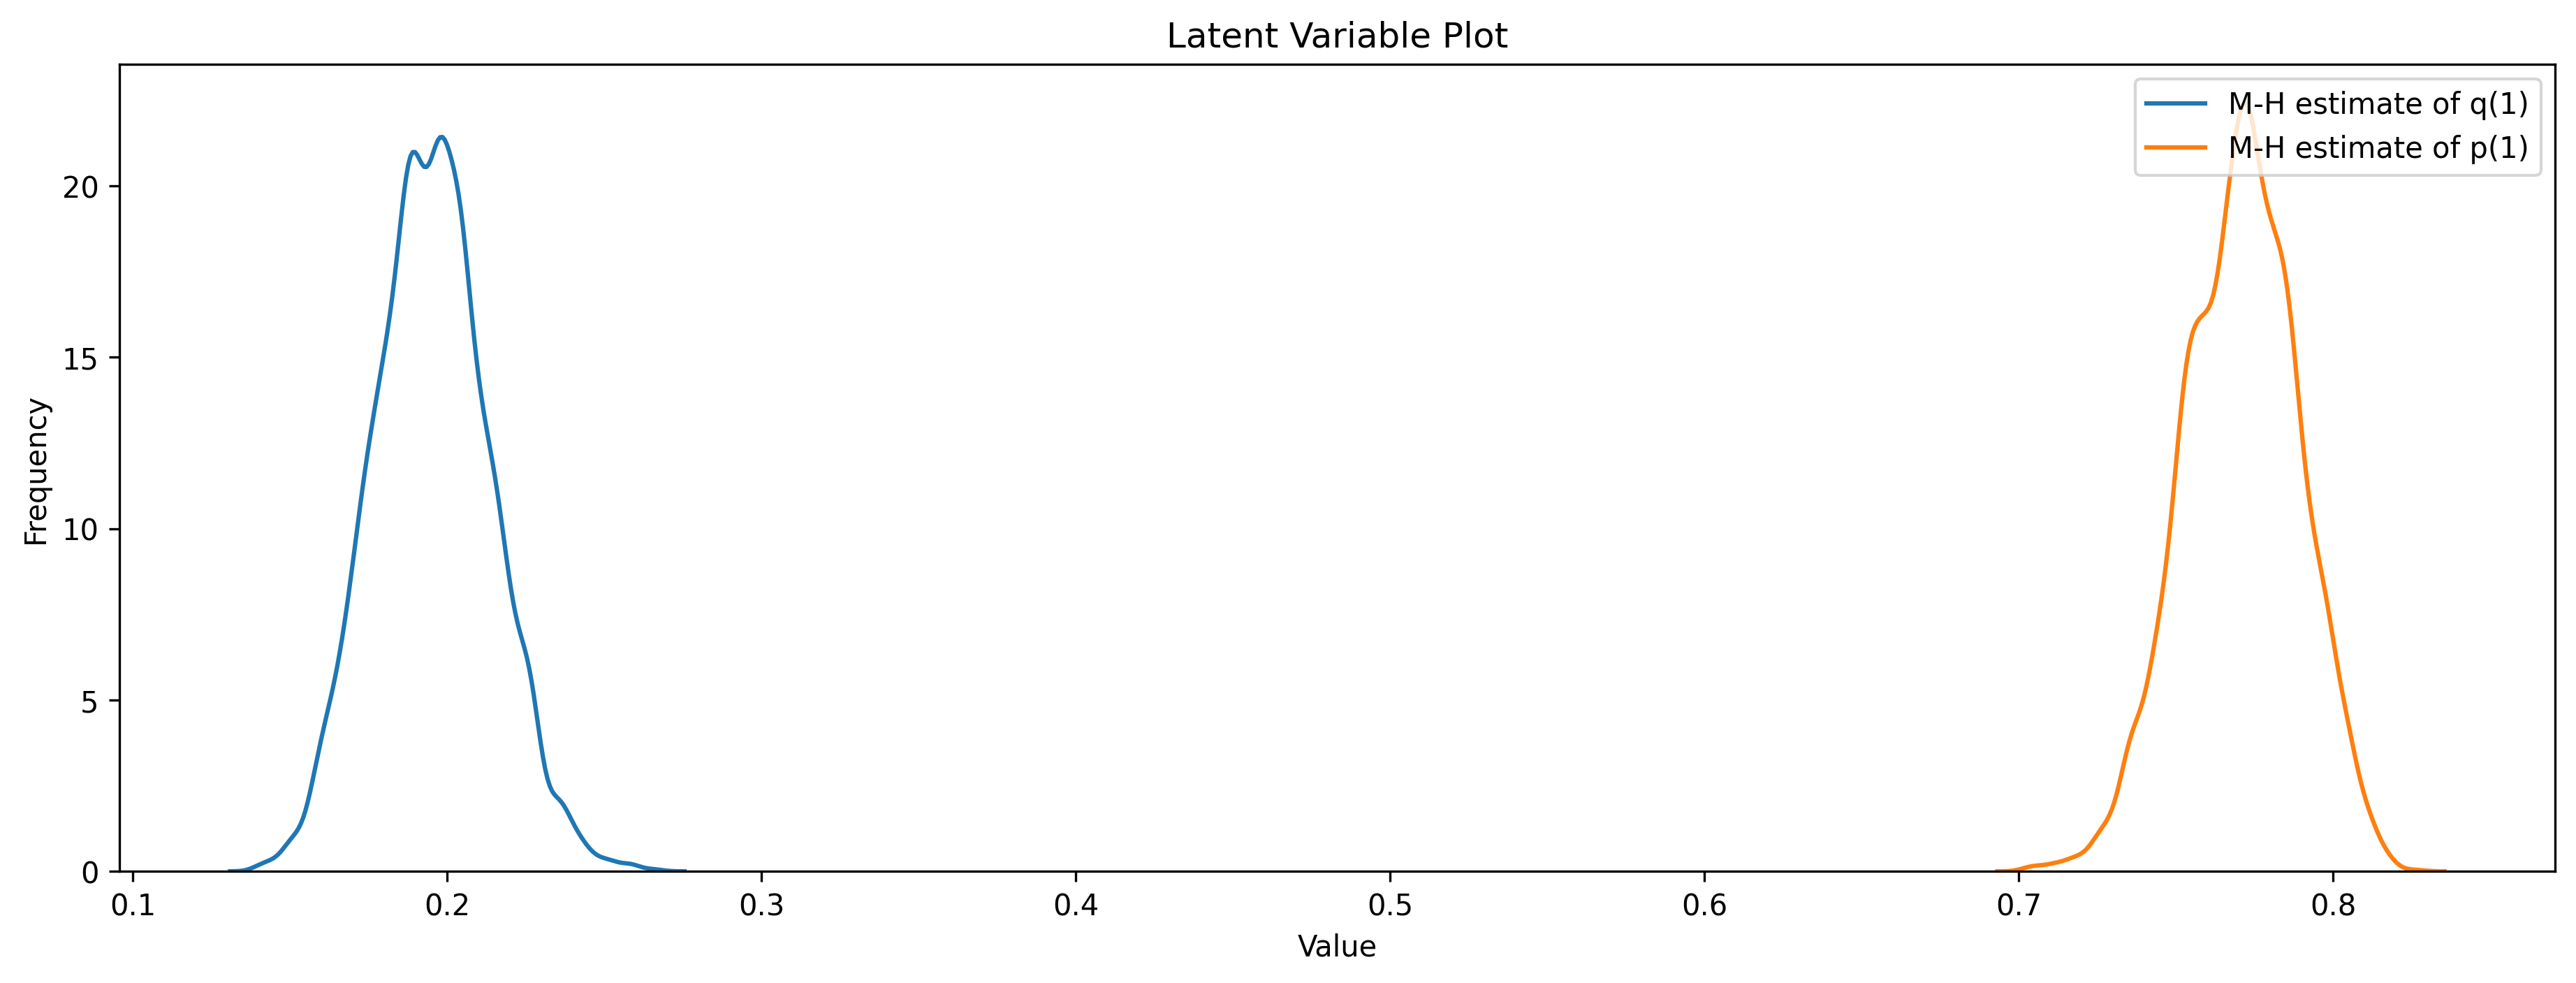

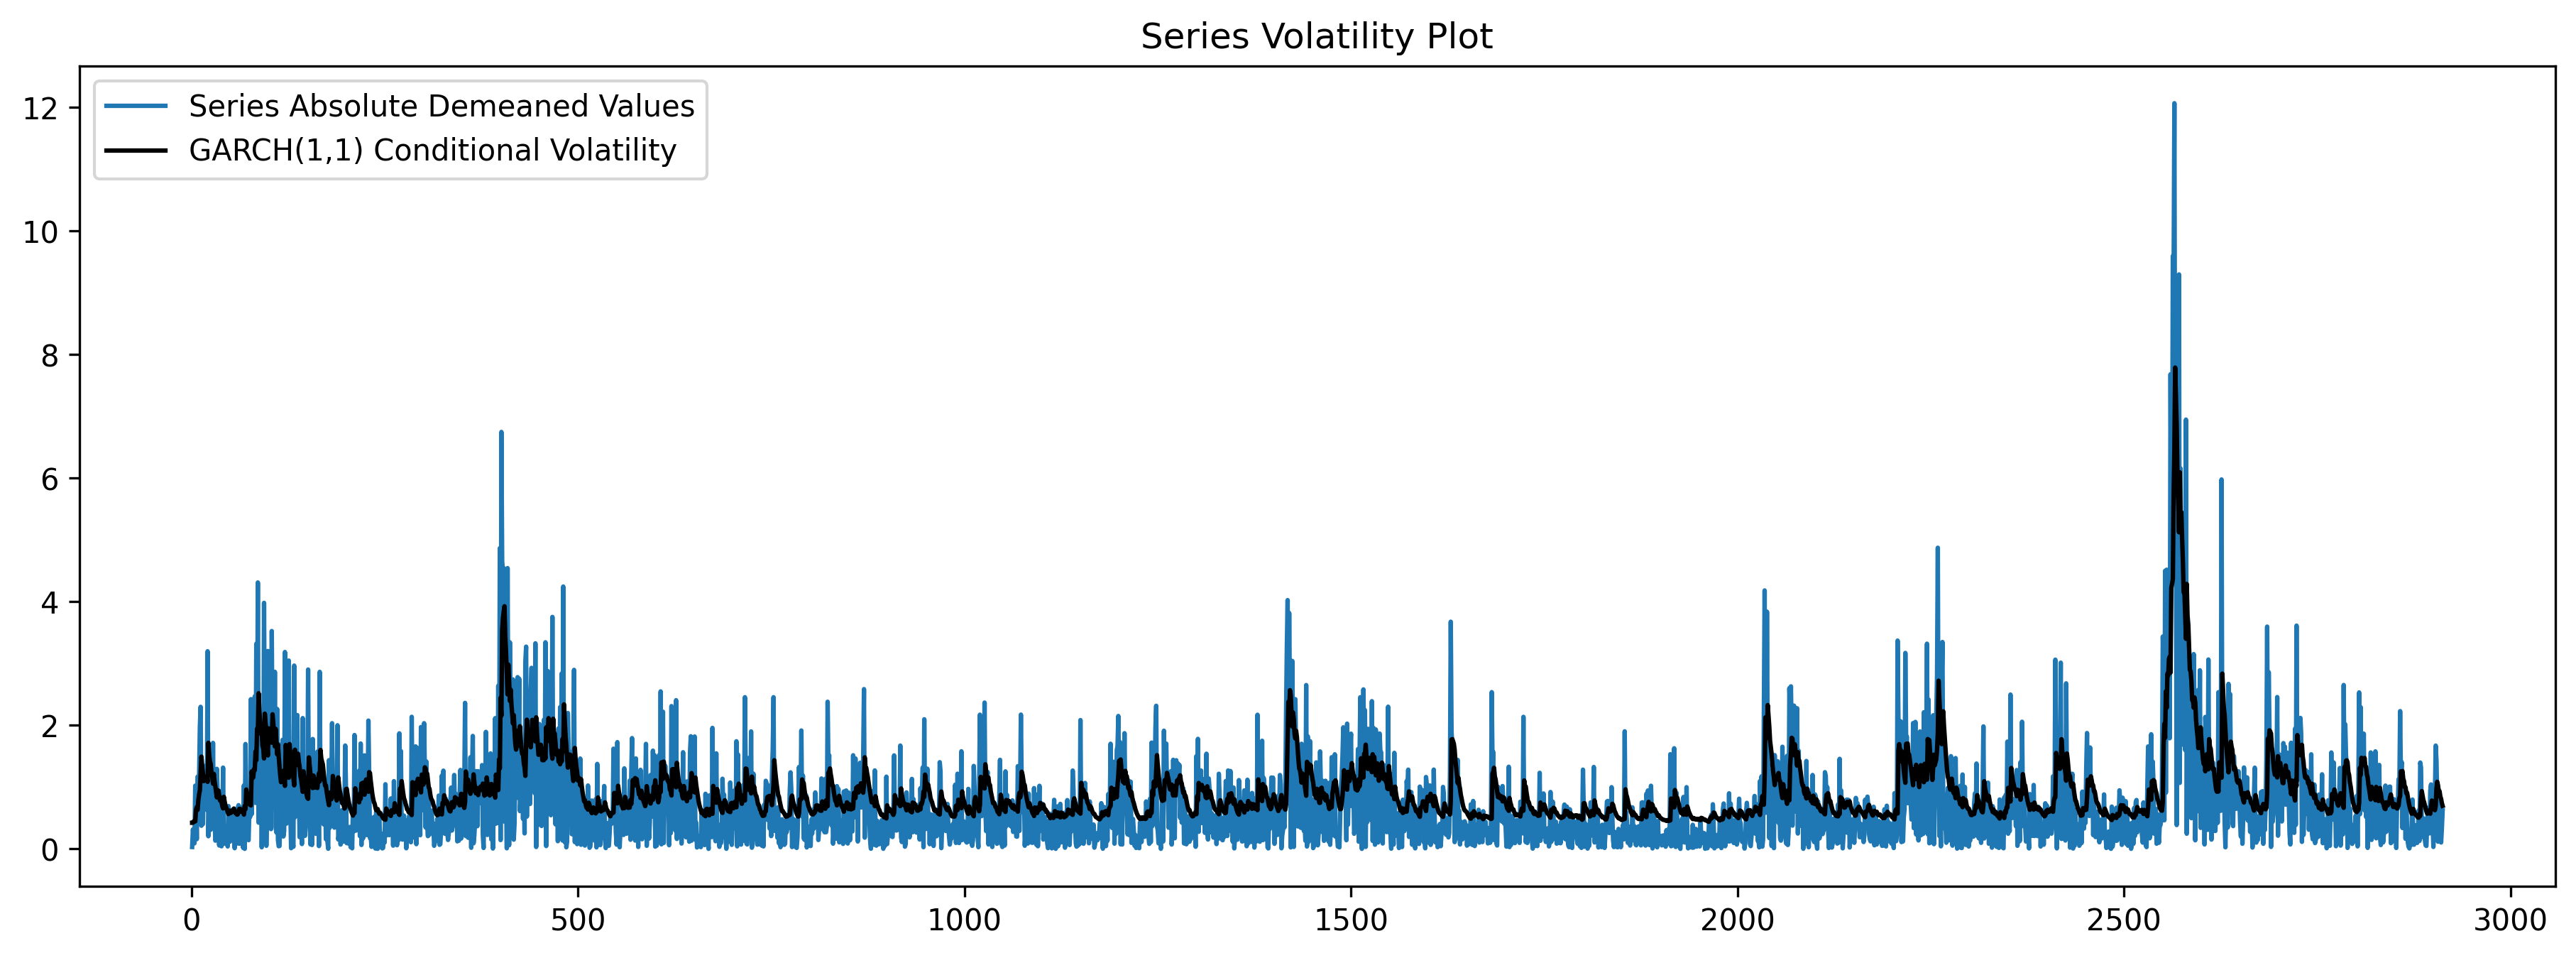

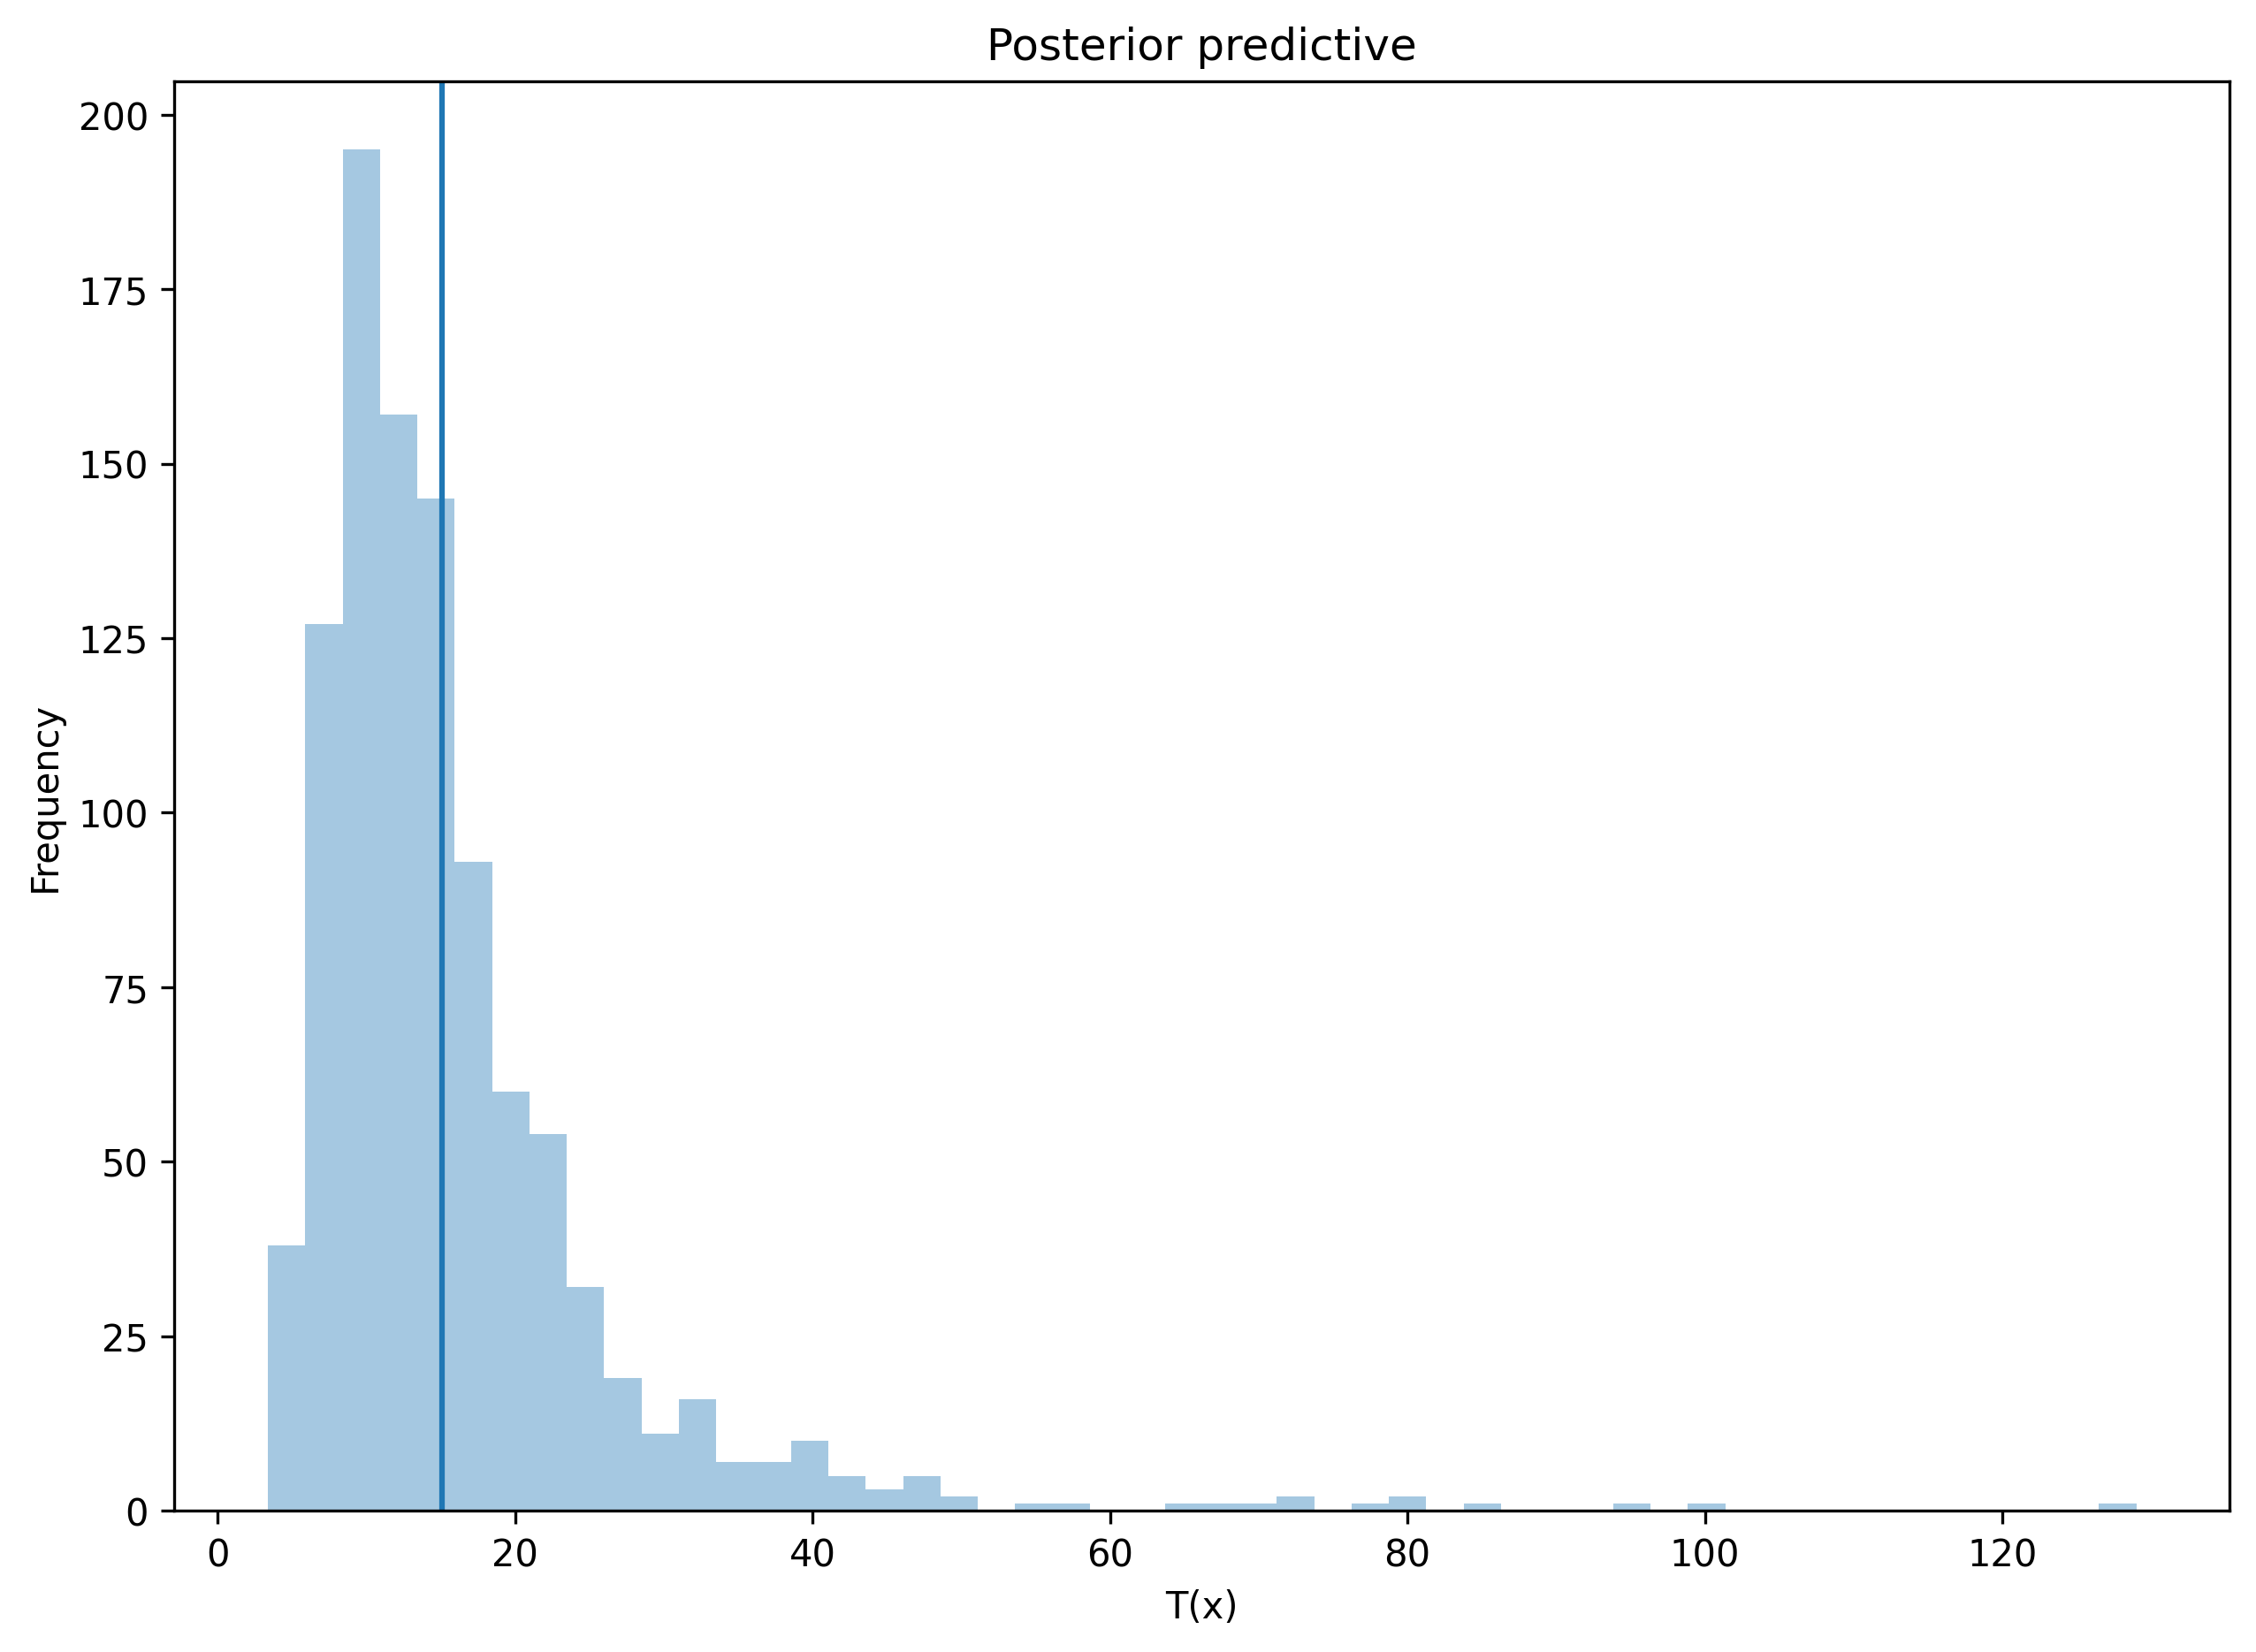

Acceptance rate of Metropolis-Hastings is 0.1131
Acceptance rate of Metropolis-Hastings is 0.1769
Acceptance rate of Metropolis-Hastings is 0.25325

Tuning complete! Now sampling.
Acceptance rate of Metropolis-Hastings is 0.2555


In [20]:
import pyflux as pf
from scipy.stats import kurtosis
model = pf.GARCH(ret.values, p=1, q=1)
print(model.latent_variables)
model.adjust_prior(1, pf.Normal())
model.adjust_prior(2, pf.Normal())
x = model.fit(method='M-H', iterations='1000')
print(x.summary())
model.plot_z([1, 2])
model.plot_fit(figsize=(15, 5))
model.plot_ppc(T=kurtosis, nsims=1000)
bayesian_prediction = model.predict_is(n, fit_method='M-H')


In [21]:
bayesian_RMSE = np.sqrt(mse(realized_vol.iloc[-n:] / 100,
                         bayesian_prediction.values / 100))
print('The RMSE of Bayesian model is {:.6f}'.format(bayesian_RMSE))

The RMSE of Bayesian model is 0.004071


In [22]:
bayesian_prediction.index = ret.iloc[-n:].index

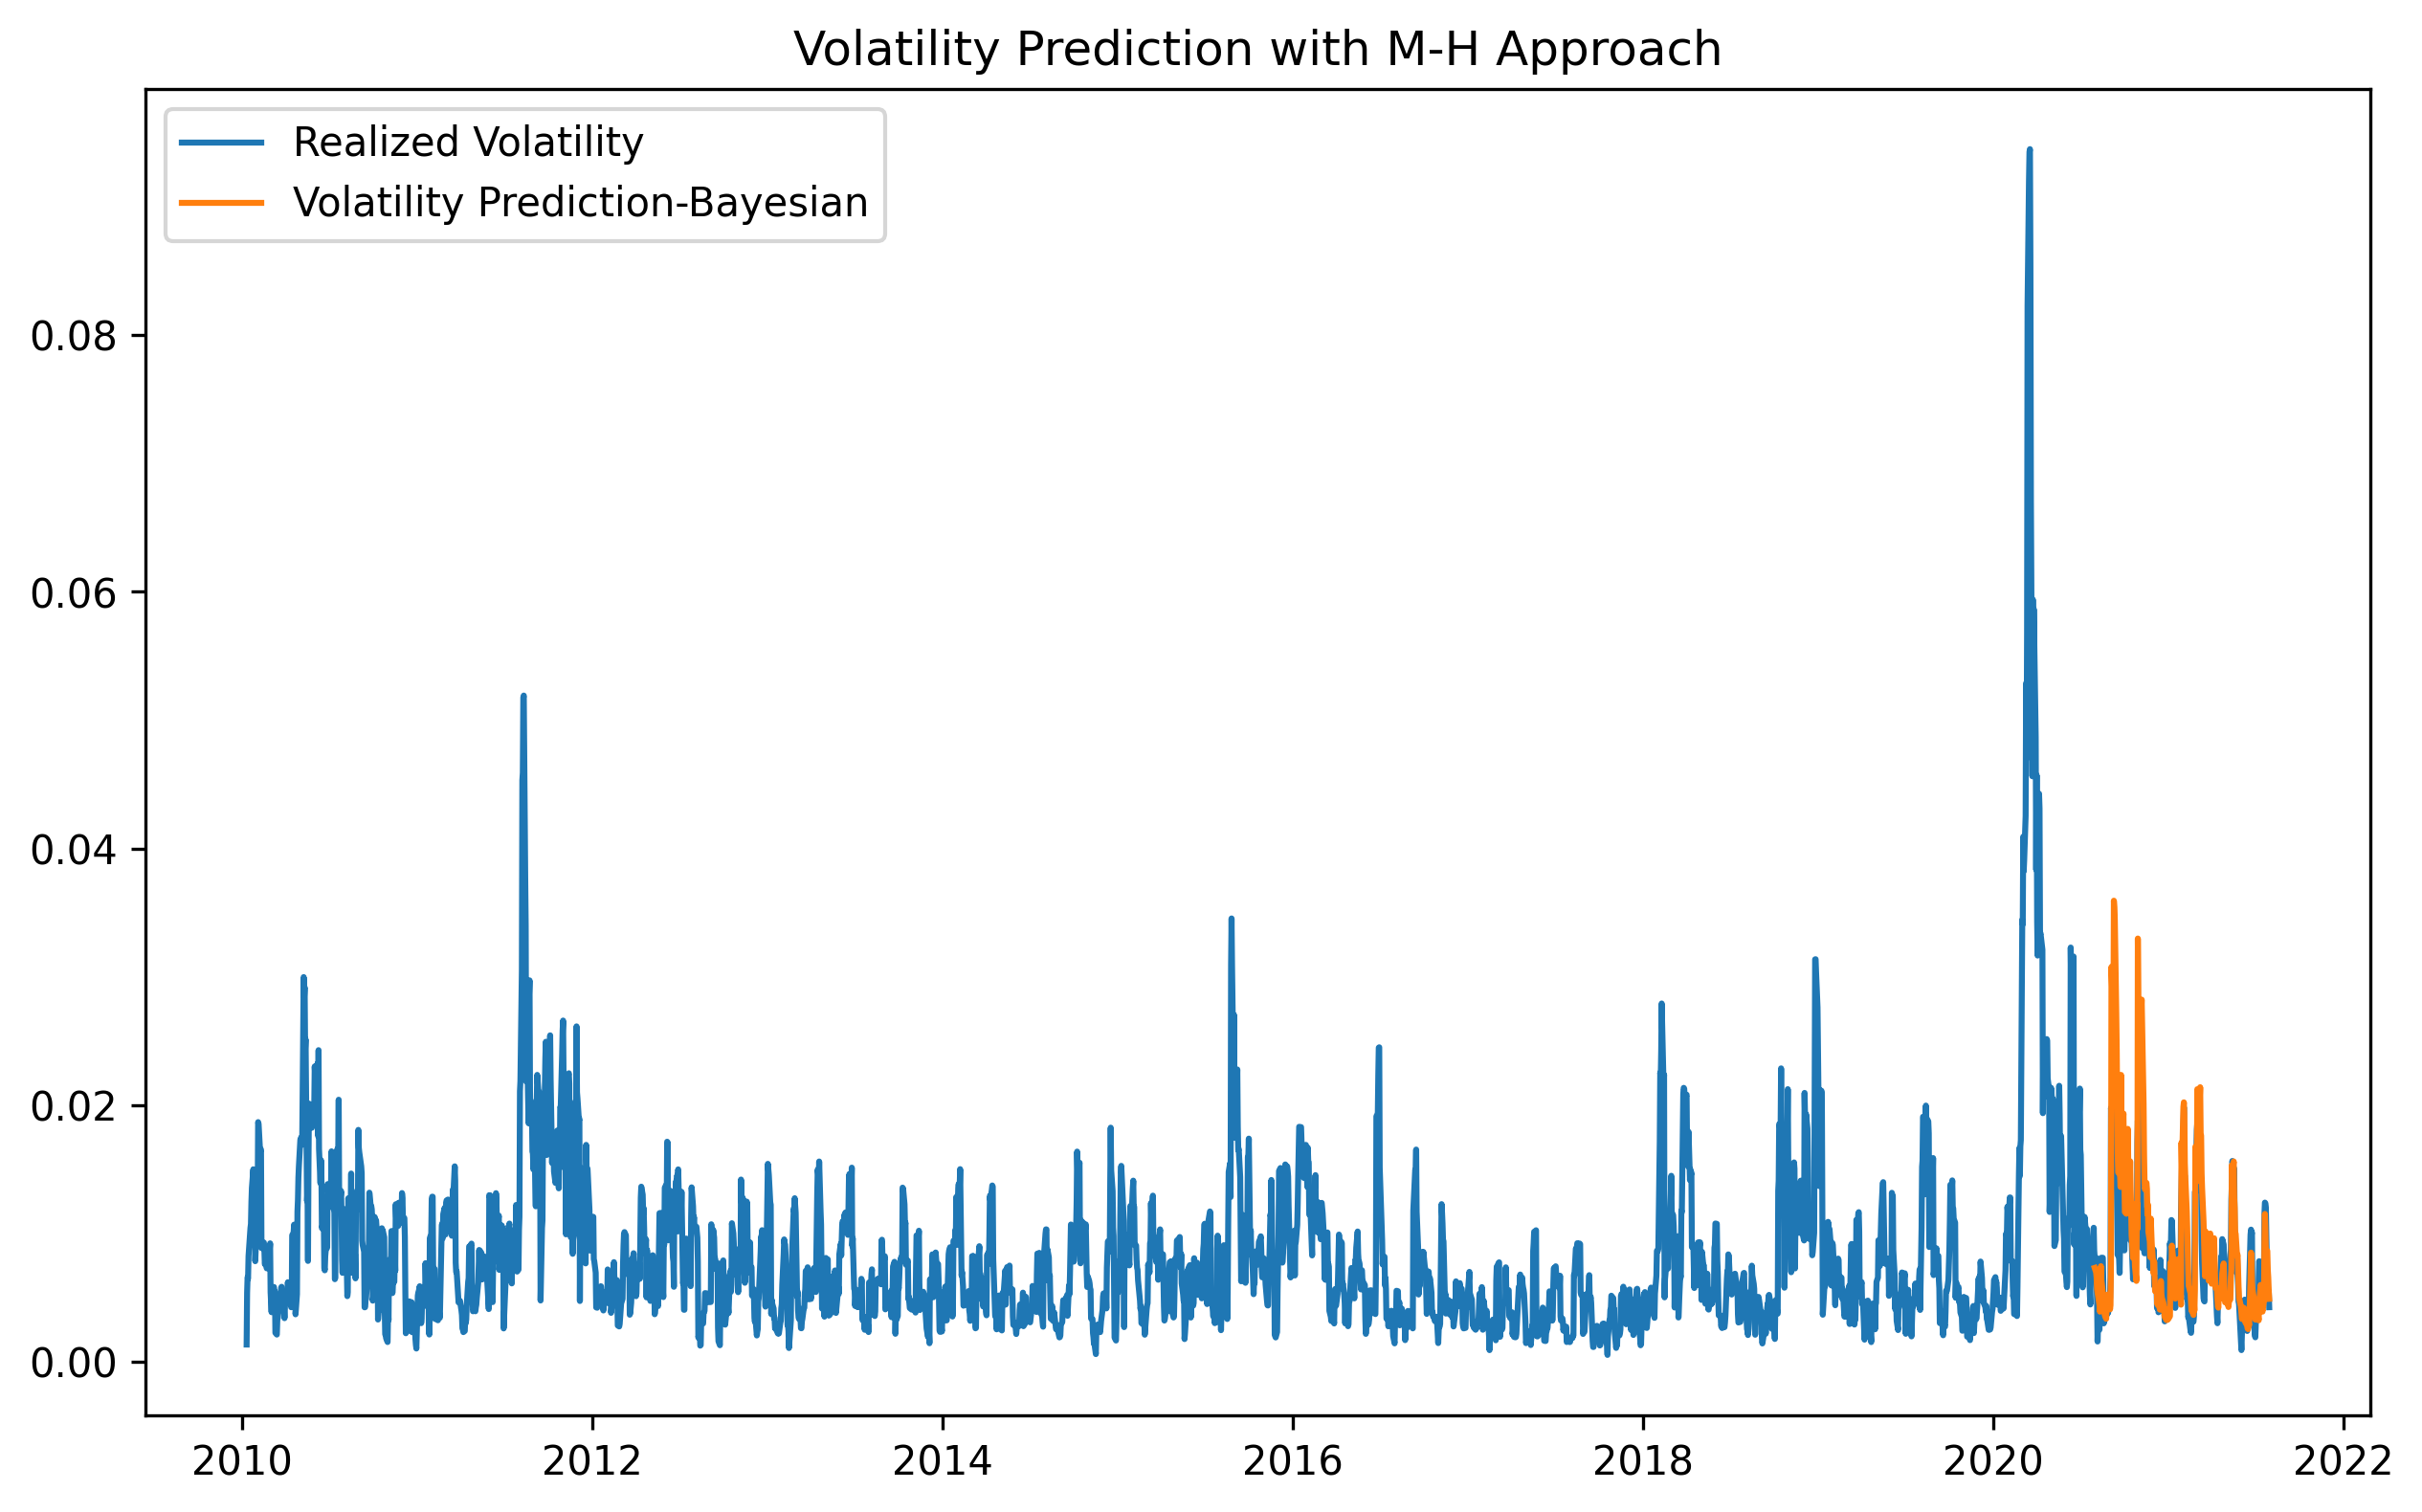

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100,
         label='Realized Volatility')
plt.plot(bayesian_prediction['Series'] / 100,
         label='Volatility Prediction-Bayesian')
plt.title('Volatility Prediction with M-H Approach', fontsize=12)
plt.legend()
plt.show()